# **Disaster Dataset (Easy)**

By: Wen Yang, Yun Xuan, Lotus, Justin 

Objective: A binary classification problem. Given a dataset that contains the details surrounding the sinking of a ship. Using this, we will predict if a person is likely to survive the disaster.

# Project Outline 

## Data Preprocessing: 

1) Importing dataset

2) Dealing with null values

3) Transformation of Numeric Features

## Descriptive Statistics

## Data Modelling: 

1) Logistic Regression 

2) Decision Tree, Random Forest, XGBoost 

3) Neural Network 






In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.ensemble import VotingClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import string
from sklearn.metrics import f1_score

# Loading the Dataset

In [4]:
data = pd.read_csv('/content/data.csv',index_col = [0])

# Checking dataset features and types

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 866 entries, 0 to 865
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  866 non-null    int64  
 1   class               866 non-null    int64  
 2   num_sibling/spouse  866 non-null    int64  
 3   num_parent/child    866 non-null    int64  
 4   ticket              866 non-null    object 
 5   price               866 non-null    float64
 6   Seat                198 non-null    object 
 7   departure_from      864 non-null    object 
 8   gender              866 non-null    object 
 9   alive               866 non-null    int64  
 10  age                 692 non-null    float64
dtypes: float64(2), int64(5), object(4)
memory usage: 81.2+ KB


We observe that there are **11** columns of data in the dataset, with alive being our target variable

Number of entries in the dataset: **866**

# Checking for null values

In [6]:
data.isnull().sum()

Id                      0
class                   0
num_sibling/spouse      0
num_parent/child        0
ticket                  0
price                   0
Seat                  668
departure_from          2
gender                  0
alive                   0
age                   174
dtype: int64

We observe that there are empty values in 3 different columns: 

*   seat
*   departure_from
*   age



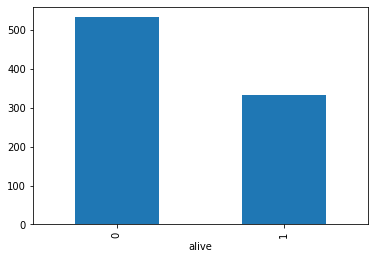

In [7]:
data.groupby('alive')['alive'].count().plot(kind = 'bar')

The proportion of those in class 1 to the entire dataset is ~40%. Our classifiers subsequently should minimally have a 40% true positive rate to be considered significant.

# Checking collinearity between variables. 

Highly correlated features might result in inaccurate weights as the correlated features are given greater importance. 

In [8]:
data.corr()

,Id,class,num_sibling/spouse,num_parent/child,price,alive,age
Id,1.000000,-0.037940,-0.045220,-0.005782,0.025964,-0.002663,0.043193
class,-0.037940,1.000000,0.085394,0.014851,-0.551861,-0.334250,-0.370110
num_sibling/spouse,-0.045220,0.085394,1.000000,0.424967,0.157930,-0.041035,-0.312569
num_parent/child,-0.005782,0.014851,0.424967,1.000000,0.218607,0.084858,-0.203935
price,0.025964,-0.551861,0.157930,0.218607,1.000000,0.256561,0.091529
alive,-0.002663,-0.334250,-0.041035,0.084858,0.256561,1.000000,-0.077078
age,0.043193,-0.370110,-0.312569,-0.203935,0.091529,-0.077078,1.000000


**Age**

We choose to fill the null values in this column with the median age of those belonging in the same class and of the same gender. We considered this as there is a non-neglible relation between age and the probability of emerging alive, and furthermore between age and class. We segregated further based on gender, as there appeared to be differences in the age group for different genders in different classes.

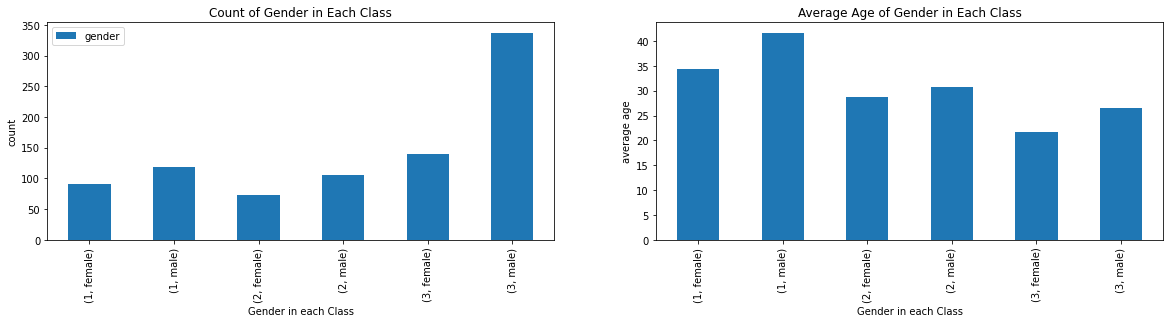

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,4))

a = pd.DataFrame(data.groupby(['class','gender'])['gender'].count())
a.plot(kind = 'bar',ax = ax1, xlabel='Gender in each Class',ylabel = 'count', title='Count of Gender in Each Class')

b = data.groupby(['class','gender'])['age'].mean()
b.plot(kind = 'bar',ax = ax2, xlabel = 'Gender in each Class', ylabel = 'average age', title = 'Average Age of Gender in Each Class')


In [10]:
data['age'] = data.groupby(['gender', 'class'])['age'].apply(lambda x: x.fillna(x.median()))
data.isnull().sum()

Id                      0
class                   0
num_sibling/spouse      0
num_parent/child        0
ticket                  0
price                   0
Seat                  668
departure_from          2
gender                  0
alive                   0
age                     0
dtype: int64

**Departure From**

In order to determine their departure location, the only useful feature seemed to be their unique ticket number, as different departure locations may have specific alphabets/numbers in their ticket. 

However, there was no clear relation found between the ticket number and location. 

Considering the very first letter of the ticket number, it was found that the value S was the modal value and hence we chose to fill null values with S.

In [11]:
data[data['departure_from'].isnull()]

,Id,class,num_sibling/spouse,num_parent/child,ticket,price,Seat,departure_from,gender,alive,age
61,62,1,0,0,Y7YW04RMB3,80.0,B28,NaN,female,1,38.0
829,830,1,0,0,Y7YW04RMB3,80.0,B28,NaN,female,1,62.0


In [12]:
Y_tickets = data['ticket'].str.contains('^Y+',regex = True)
data[Y_tickets==True].groupby('departure_from')['departure_from'].count()
data['departure_from'] = data['departure_from'].fillna('S')

**Seat**

We chose to drop the seat feature as there were too many missing values to approximate. It did not make sense to approximate as well, because each seat is meant to be uniquely tied to their ticket number. 

In [13]:
data.drop('Seat',axis=1,inplace=True)

# Data Transformation

We start off by encoding the gender variable to convert it into a numeric value for use in our models later.

In [14]:
data['gender'] = data['gender'].map({'male':1,'female':0})

Subsequently, we created a new variable, 'family_size' by merging the correlated columns, as shown below.

In [15]:
data['family_size'] = data['num_sibling/spouse'] + data['num_parent/child'] + 1

We sieve out the numeric columns and obtain 2 new dataframes:

X consisting of our numeric dependent variables 

Y consisting of our target variable

In [16]:
data_numeric = data.select_dtypes(include = np.number)
data_numeric

,Id,class,num_sibling/spouse,num_parent/child,price,gender,alive,age,family_size
0,1,3,1,0,7.2500,1,0,22.0,2
1,2,1,1,0,71.2833,0,1,38.0,2
2,3,3,0,0,7.9250,0,1,26.0,1
3,4,1,1,0,53.1000,0,1,35.0,2
4,5,3,0,0,8.0500,1,0,35.0,1
...,...,...,...,...,...,...,...,...,...
861,862,2,1,0,11.5000,1,0,21.0,2
862,863,1,0,0,25.9292,0,1,48.0,1
863,864,3,8,2,69.5500,0,0,21.0,11
864,865,2,0,0,13.0000,1,0,24.0,1


In [17]:
x=data_numeric.drop(["alive",'Id','num_sibling/spouse','num_parent/child'],axis=1)
y=data_numeric["alive"]

We perform feature scaling on price, age and family_size as their units of measurements are different. 

Because machine learning algorithms take just the magnitude of features neglecting the units, higher weightage may be given to features with higher magnitude, like price, if features are left unscaled. Without scaling, family_size (with its smaller values) would likely end up with a lower weight than it is meant to. 

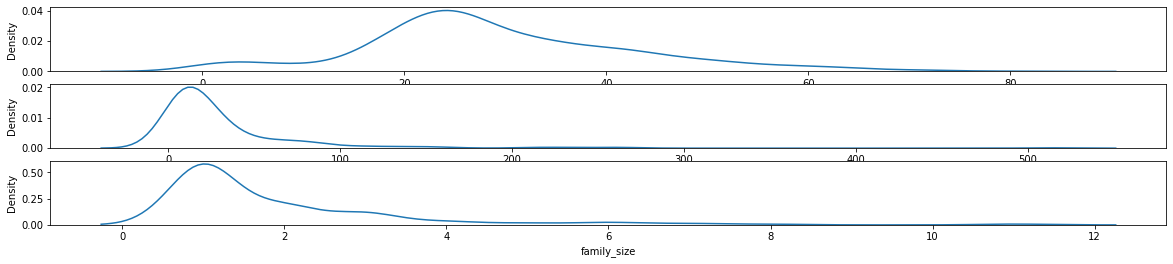

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,4))
sns.kdeplot(data['age'],ax = ax1)
sns.kdeplot(data['price'],ax = ax2)
sns.kdeplot(data['family_size'],ax = ax3)

The numeric age, price and family size columns have a skewed normal distribution. We understand that this may potentially affect the classification algorithms especially logistic regression, which naturally assumes a normal distribution.

In [19]:
col_names = ['price', 'age','family_size']
features = data_numeric[col_names]
scaled_features = StandardScaler().fit_transform(features.values)
x[col_names] = scaled_features


# Data Modelling

# Train-test Split
We perform a train-test split in order to obtain a set of training data and a set of test data, which we then feed into the various machine learning algorithms to test their predictive performance. 

In [20]:
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.25,random_state=1)

In [21]:
x.shape

(866, 5)

# Model 1: Logistic Regression

We start off with Logistic Regression, the classification algorithm most appropriate for binary classification problems, like the Titanic dataset.  

Logistic regression is a supervised classification algorithm that assigns data to a discrete set of classes. It is used to estimate the probability of the occurrence of an event, in our case, on whether a person survives a disaster.
The values are bounded between 0 and 1, while the output is either 0 or 1.

𝑦=𝑔(𝐖.𝐱𝑇)

In [22]:
lm= LogisticRegression()
lm.fit(x_train,y_train)
pred = lm.predict(x_val)

In [23]:
print(classification_report(y_val,pred))
cm = metrics.confusion_matrix(y_val, pred)
print(cm)

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       133
           1       0.78      0.64      0.71        84

    accuracy                           0.79       217
   macro avg       0.79      0.77      0.77       217
weighted avg       0.79      0.79      0.79       217

[[118  15]
 [ 30  54]]


A simple logistic Regression on all variables gives us a good baseline score of

Precision - 0.80

Recall - 0.89

F1-score - 0.84

Accuracy - 0.79


Given the slight uneven distribution of classes in the dataset, and the different cost of a false positive or false negative:


*   Having a high precision -> low false positive rate: Priortizing this metric ensures we don't waste resources finding people who are likely dead already 
*   Having high recall -> low false negative rate: Priortizing this metric ensures we don't give up the rescue effort before everyone is saved


We will utilize the F1-score which is the weighted average of Precision and Recall, which takes both false positives and false negatives into account.

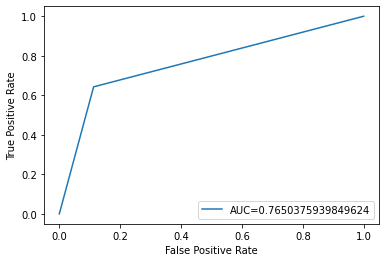

In [24]:
fpr, tpr, _ = metrics.roc_curve(y_val, pred) 
auc = metrics.roc_auc_score(y_val, pred)

plt.plot(fpr,tpr,label="AUC="+str(auc)) 
plt.ylabel('True Positive Rate') 
plt.xlabel('False Positive Rate') 
plt.legend(loc=4)
plt.show()

A ROC curve along with AUC value were plotted and calculated respectively. A high AUC of 0.79 indicates that the model predicts accurately.

# Model 2: Random Forest

Random forest is a model made up of multiple decision trees. The algorithm uses both the bagging method and feature randomness to ensure a low correlation between the decision trees.

In [25]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 1)
rf.fit(x_train, y_train)
pred2 = rf.predict(x_val)

print(classification_report(y_val,pred2))
cm = metrics.confusion_matrix(y_val, pred2)
print(cm)

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       133
           1       0.81      0.64      0.72        84

    accuracy                           0.80       217
   macro avg       0.80      0.77      0.78       217
weighted avg       0.80      0.80      0.80       217

[[120  13]
 [ 30  54]]


An untuned Random Forest performs marginally better than our initial logistic regression model, with a F1-score of 0.85. 



# Model 3: Hyperparameter Tuned Random Forest

We tune the hyperparameters of the random forest in order to obtain the best set that optimizes output and minimizes loss.

In [26]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [27]:
rf_tuned = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf_tuned, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=1, n_jobs = -1)

rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1, verbose=2)

In [28]:
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

In [29]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf_tuned2 = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf_tuned2, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [30]:
pred3 = grid_search.predict(x_val)

print(classification_report(y_val,pred3))
cm = metrics.confusion_matrix(y_val, pred3)
print(cm)

              precision    recall  f1-score   support

           0       0.79      0.90      0.85       133
           1       0.80      0.63      0.71        84

    accuracy                           0.80       217
   macro avg       0.80      0.77      0.78       217
weighted avg       0.80      0.80      0.79       217

[[120  13]
 [ 31  53]]


Our hyperparameter-tuned random forest did not produce significantly better results than the untuned random forest with a F1-score of 0.85. However, there was a trade-off between precision and recall.

# Model 4: Extreme Gradient Boosting (XGBoost)

Extreme Gradient Boosting is an efficient implementation of a class of ensemble machine learning algorithms, which is referred to as boosting. The loss gradient is minimized as the model is fit, utilzing the gradient descent algorithm.

In [31]:
xgb = xgboost.XGBClassifier()

In [32]:
params = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [33]:
xgb_random=RandomizedSearchCV(xgb,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

In [34]:
xgb_random.fit(x_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=XGBClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='roc_auc', verbose=3)

In [35]:
xgb_random.best_params_

{'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.25,
 'gamma': 0.4,
 'colsample_bytree': 0.7}

In [36]:
xgb_tuned=xgboost.XGBClassifier(min_child_weight= 3,max_depth= 15,learning_rate= 0.05,gamma= 0.3,colsample_bytree= 0.5)
xgb_tuned1=xgboost.XGBClassifier(min_child_weight= 3,max_depth= 15,learning_rate= 0.05,gamma= 0.3,colsample_bytree= 0.5)

In [37]:
xgb_tuned.fit(x_train,y_train)

XGBClassifier(colsample_bytree=0.5, gamma=0.3, learning_rate=0.05, max_depth=15,
              min_child_weight=3)

In [38]:
ypredxgb=xgb_tuned.predict(x_val)
print(classification_report(y_val,ypredxgb))
cm = metrics.confusion_matrix(y_val, ypredxgb)
print(cm)

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       133
           1       0.82      0.65      0.73        84

    accuracy                           0.81       217
   macro avg       0.81      0.78      0.79       217
weighted avg       0.81      0.81      0.81       217

[[121  12]
 [ 29  55]]


The XGBoost algorithm performed marginally better than the previous two models, with an improvement in F1-score.

# Model 5: Soft Voting Classifier

Soft Voting Classifier takes every individual classifier’s probability value that a specific data point belongs to a target class, and in our project — whether a person survives. The predicted are weighted by the classifier’s importance and summed up, after which the target label with the greatest sum of weighted probability wins the vote. 

In our project, a confusion matrix is created to determine the F1 score and the accuracy of the model.

In [39]:
vc=VotingClassifier(estimators=[('xgb',xgb_tuned1),('rf',grid_search)],voting="soft")
vc.fit(x_train,y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(colsample_bytree=0.5, gamma=0.3,
                                            learning_rate=0.05, max_depth=15,
                                            min_child_weight=3)),
                             ('rf',
                              GridSearchCV(cv=3,
                                           estimator=RandomForestClassifier(),
                                           n_jobs=-1,
                                           param_grid={'bootstrap': [True],
                                                       'max_depth': [80, 90,
                                                                     100, 110],
                                                       'max_features': [2, 3],
                                                       'min_samples_leaf': [3,
                                                                            4,
                                                      

In [40]:
vcpred=vc.predict(x_val)

In [41]:
print(classification_report(y_val,vcpred))
cm = metrics.confusion_matrix(y_val, vcpred)
print(cm)

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       133
           1       0.84      0.64      0.73        84

    accuracy                           0.82       217
   macro avg       0.82      0.78      0.79       217
weighted avg       0.82      0.82      0.81       217

[[123  10]
 [ 30  54]]


# Model 6: Neural Network 

Neural Network is a method in artificial intelligence that uses interconnected nodes or neurons, with hidden layers to train a model. 

In our project, we chose the Keras deep learning framework with relu and sigmoid activation layers to train the model. The loss function and binary accuracy graphs have also been plotted to illustrate the decrease and increase respectively with each epoch.

In [45]:
model = keras.Sequential([
    keras.Input(shape=(5,)),
    keras.layers.Dense(units=6),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Dense(units=4),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Dense(units=1),
    keras.layers.Activation(keras.activations.sigmoid),
])

Epoch 1/10
65/65 [==============================] - 1s 5ms/step - loss: 0.7479 - binary_accuracy: 0.6148 - val_loss: 0.6729 - val_binary_accuracy: 0.6313
Epoch 2/10
65/65 [==============================] - 0s 3ms/step - loss: 0.6967 - binary_accuracy: 0.6256 - val_loss: 0.6462 - val_binary_accuracy: 0.6498
Epoch 3/10
65/65 [==============================] - 0s 2ms/step - loss: 0.6707 - binary_accuracy: 0.6348 - val_loss: 0.6330 - val_binary_accuracy: 0.6544
Epoch 4/10
65/65 [==============================] - 0s 3ms/step - loss: 0.6554 - binary_accuracy: 0.6317 - val_loss: 0.6241 - val_binary_accuracy: 0.6636
Epoch 5/10
65/65 [==============================] - 0s 3ms/step - loss: 0.6438 - binary_accuracy: 0.6364 - val_loss: 0.6176 - val_binary_accuracy: 0.6636
Epoch 6/10
65/65 [==============================] - 0s 2ms/step - loss: 0.6352 - binary_accuracy: 0.6410 - val_loss: 0.6110 - val_binary_accuracy: 0.6774
Epoch 7/10
65/65 [==============================] - 0s 3ms/step - loss: 0.62

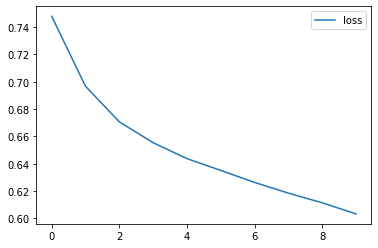

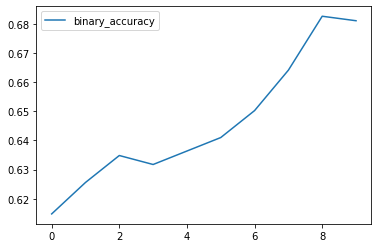

In [46]:
opt = tf.optimizers.SGD(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])
history = model.fit(x_train,y_train,epochs = 10, batch_size = 10,validation_data=(x_val, y_val))
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss']].plot()
history_frame.loc[:, ['binary_accuracy']].plot();

In [47]:
y_pred = np.round(model.predict(x_val)).astype(int)
f1 = f1_score(y_val, y_pred)
print(f1)
matrix = metrics.confusion_matrix(y_val, y_pred)
print(matrix)

7/7 [==============================] - 0s 2ms/step
0.45454545454545453
[[132   1]
 [ 59  25]]


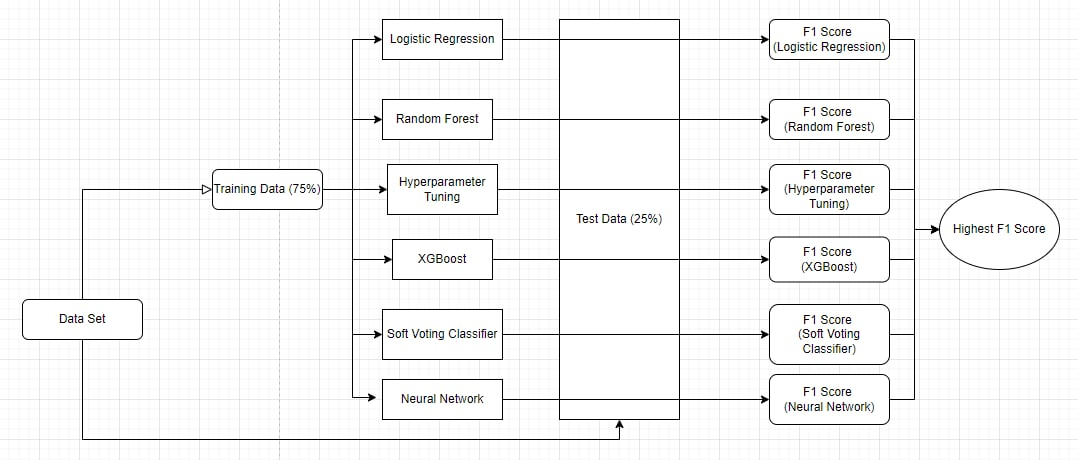

A Flowchart of the solution process

# Conclusion

By using the various Machine Learning algorithms, we managed to predict the probability of survival given the different characteristics. Out of the 6 models we have experimented with, the Soft Voting Classifier produced the best results in terms of F1-score. We find that accuracy, while important, may not always be the best metric for evaluating performance, and this is due to the imbalanced data as most people in the dataset did not survive the disaster.